In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["study", "date", "time","meeting","emotional","modern","cozy","nature_freindly", "takeout", "retro"]

print(torch.__version__)

2.4.1+cu121


In [ ]:
!unzip -q -o data.zip

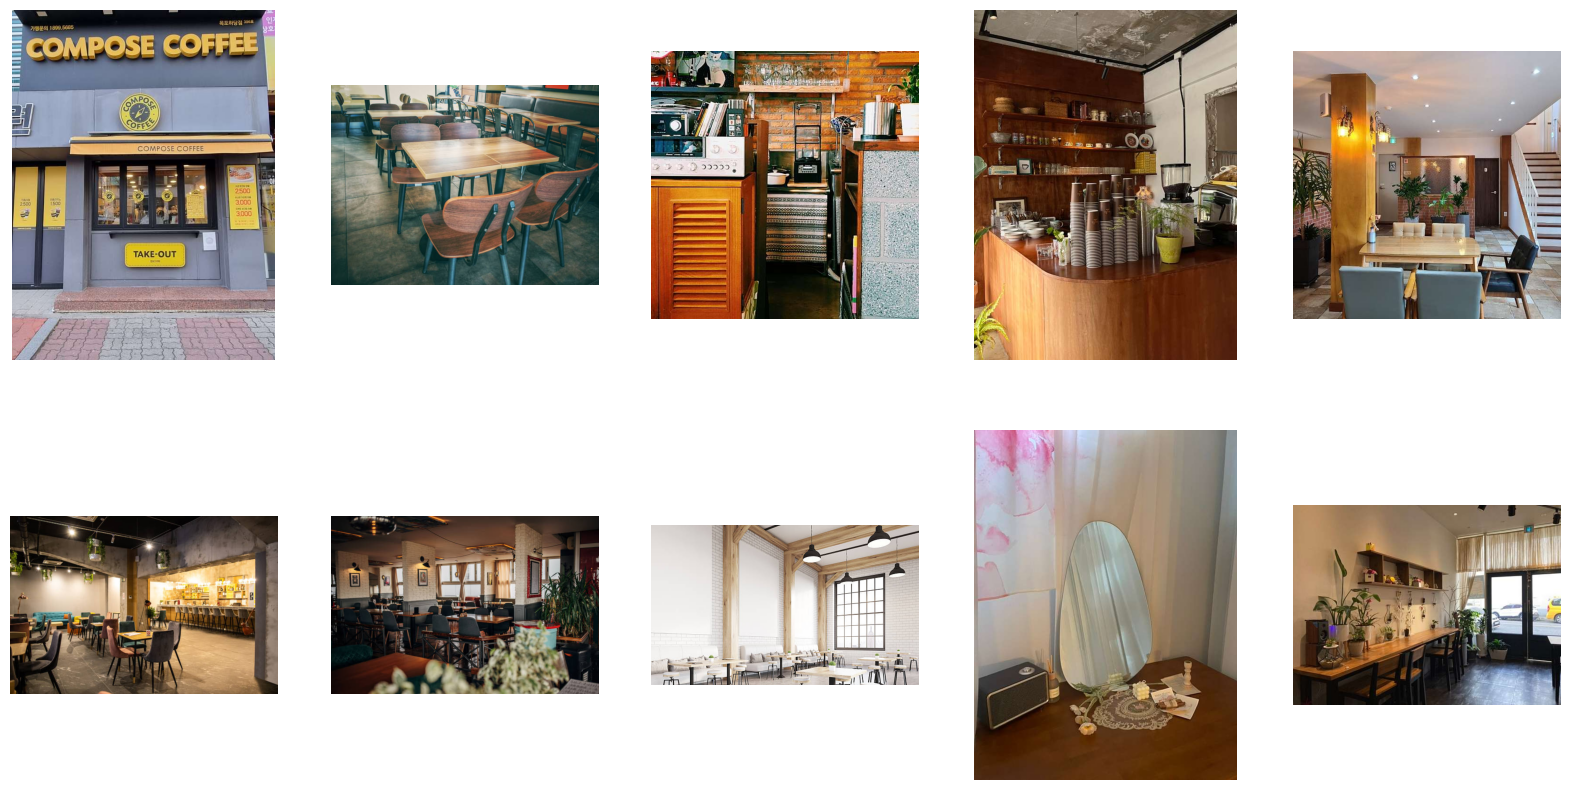

In [ ]:
import os
import random

image_folder_path = 'original'

# 폴더 내의 모든 파일 목록을 가져옵니다.
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

# 랜덤하게 10개의 이미지를 선택합니다. (이미지 수가 10개 미만일 경우 모든 이미지를 선택)
selected_images = random.sample(image_files, min(10, len(image_files)))

# 선택된 이미지를 출력합니다.
plt.figure(figsize=(20, 10))  # 출력될 이미지 크기를 설정합니다.
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)  # 2행 5열의 그리드에서 이미지를 출력합니다.
    plt.imshow(img)
    plt.axis('off')  # 축을 보이지 않게 합니다.
plt.show()

In [ ]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df.image = df.image.astype( str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))
print(df.tail(10))

image    object
dtype: object
    image  study  date  time  meeting  emotional  modern  cozy  \
0   1.jpg      1     0     0        0          0       0     1   
1   2.jpg      1     0     1        0          0       0     1   
2   3.jpg      1     0     0        0          0       0     1   
3   4.jpg      1     0     0        0          0       0     1   
4   5.jpg      1     0     0        0          0       0     1   
5   6.jpg      1     0     0        0          0       0     1   
6   7.jpg      1     0     0        0          0       0     1   
7   8.jpg      1     0     0        0          0       0     1   
8   9.jpg      1     0     0        0          0       0     1   
9  10.jpg      1     0     0        0          0       0     1   

   nature_freindly  takeout  retro  
0                0        0      1  
1                0        0      0  
2                1        0      0  
3                0        0      0  
4                0        0      0  
5                0   

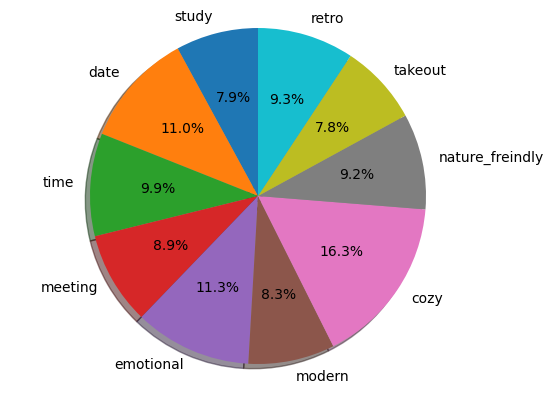

In [ ]:
df = pd.read_csv("data.csv")
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

5001.jpg


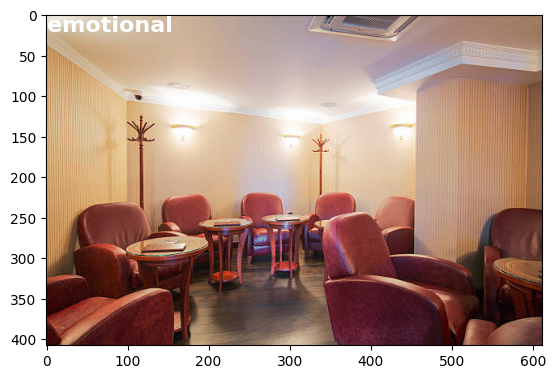

In [ ]:
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd['image']
    label = fd[1:].to_numpy()
    print(image)
    image = Image.open("original/" + image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes = np.array(classLabels)[label.astype(np.bool_)]  # np.bool 대신 np.bool_ 사용
    for i, s in enumerate(classes):
        ax.text(0, i * 20, s, verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()

visualizeImage(5000)

In [ ]:
#데이터 셋 내의 이미지 크기가 달라서 한번 출력해 봄
l= []
for i in df.image:
  with Image.open(Path("original")/i) as f:
    l.append(f.size)

np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([561.88398115, 569.6800157 ]), array([560., 560.]))

In [ ]:
#데이터 피딩을 위한 작업

class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):

    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms

  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)

    if self.transforms is not None:
      image = self.transforms(image)
    return image,label

  def __len__(self):
    return len(self.df)

In [ ]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) ,
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)

# train, valid 셋 구분

valid_no = int(len(dataset)*0.1)
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 4585 valset len 509


In [ ]:
# resnet50모델로 전이학습 하겠습니다.

model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


2048


In [ ]:
# 우리 목적에 맞게 resnet 머리(fully connected layer)를 만들어 줍니다.

def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
top_head = create_head(num_features , len(classLabels)) # because ten classes
top_head = top_head.to(device)
model.fc = top_head # replace the fully connected layer

cuda


In [ ]:
#모델을 출력해 봅니다.

from torchvision import models
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#다른 방법으로 모델을 출력해 봅니다.
for name, param in model.named_parameters():
    print(f"Layer Name: {name}, Parameter Size: {param.size()}")

Layer Name: conv1.weight, Parameter Size: torch.Size([64, 3, 7, 7])
Layer Name: bn1.weight, Parameter Size: torch.Size([64])
Layer Name: bn1.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv1.weight, Parameter Size: torch.Size([64, 64, 1, 1])
Layer Name: layer1.0.bn1.weight, Parameter Size: torch.Size([64])
Layer Name: layer1.0.bn1.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv2.weight, Parameter Size: torch.Size([64, 64, 3, 3])
Layer Name: layer1.0.bn2.weight, Parameter Size: torch.Size([64])
Layer Name: layer1.0.bn2.bias, Parameter Size: torch.Size([64])
Layer Name: layer1.0.conv3.weight, Parameter Size: torch.Size([256, 64, 1, 1])
Layer Name: layer1.0.bn3.weight, Parameter Size: torch.Size([256])
Layer Name: layer1.0.bn3.bias, Parameter Size: torch.Size([256])
Layer Name: layer1.0.downsample.0.weight, Parameter Size: torch.Size([256, 64, 1, 1])
Layer Name: layer1.0.downsample.1.weight, Parameter Size: torch.Size([256])
Layer Name: layer1.0.downsample

In [ ]:
# 모델의 바닥 일부를 freezing합니다.
# 'conv1', 'bn1', 'relu', 'maxpool', 'layer1'을 포함한 초기 레이어를 freeze

for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        break  # 'layer1' 다음 레이어에 도달하면 loop 종료


In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#loss 함수와 옵티마이져, 스케줄로를 정의합비다.
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [ ]:
# 정확도 값으로 f1_스코어를 사용하고 있네요
# tqdm은 학습 진행정도를 시각화 해줍니다.

from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()

      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0

      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.9
          preds = preds.to(torch.float32)

          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)


      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [ ]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=300)

Epochs:   0%|          | 1/300 [00:51<4:16:29, 51.47s/it]

['train Loss: 0.4561 Acc: 0.0061', 'val Loss: 0.3675 Acc: 0.0242']


Epochs:   1%|          | 2/300 [01:42<4:14:44, 51.29s/it]

['train Loss: 0.3654 Acc: 0.0103', 'val Loss: 0.3536 Acc: 0.0000']


Epochs:   1%|          | 3/300 [02:33<4:13:25, 51.20s/it]

['train Loss: 0.3510 Acc: 0.0138', 'val Loss: 0.4511 Acc: 0.0141']


Epochs:   1%|▏         | 4/300 [03:25<4:13:24, 51.37s/it]

['train Loss: 0.3333 Acc: 0.0250', 'val Loss: 0.3744 Acc: 0.0262']


Epochs:   2%|▏         | 5/300 [04:17<4:13:35, 51.58s/it]

['train Loss: 0.3013 Acc: 0.0495', 'val Loss: 0.3405 Acc: 0.0472']


Epochs:   2%|▏         | 6/300 [05:09<4:12:57, 51.62s/it]

['train Loss: 0.2509 Acc: 0.1042', 'val Loss: 0.3493 Acc: 0.0478']


Epochs:   2%|▏         | 7/300 [06:00<4:12:25, 51.69s/it]

['train Loss: 0.1892 Acc: 0.1985', 'val Loss: 0.3840 Acc: 0.0819']


Epochs:   3%|▎         | 8/300 [06:52<4:11:48, 51.74s/it]

['train Loss: 0.1244 Acc: 0.3732', 'val Loss: 0.4003 Acc: 0.0845']


Epochs:   3%|▎         | 9/300 [07:44<4:10:43, 51.70s/it]

['train Loss: 0.0840 Acc: 0.5306', 'val Loss: 0.3926 Acc: 0.1153']


Epochs:   3%|▎         | 10/300 [08:35<4:09:47, 51.68s/it]

['train Loss: 0.0702 Acc: 0.6257', 'val Loss: 0.4490 Acc: 0.1365']


Epochs:   4%|▎         | 11/300 [09:27<4:08:29, 51.59s/it]

['train Loss: 0.0978 Acc: 0.5578', 'val Loss: 0.5056 Acc: 0.1195']


Epochs:   4%|▍         | 12/300 [10:18<4:07:17, 51.52s/it]

['train Loss: 0.1380 Acc: 0.4355', 'val Loss: 0.5271 Acc: 0.1195']


Epochs:   4%|▍         | 13/300 [11:10<4:06:24, 51.52s/it]

['train Loss: 0.1253 Acc: 0.4615', 'val Loss: 0.4869 Acc: 0.1310']


Epochs:   5%|▍         | 14/300 [12:02<4:06:38, 51.74s/it]

['train Loss: 0.1058 Acc: 0.5476', 'val Loss: 0.5242 Acc: 0.1680']


Epochs:   5%|▌         | 15/300 [12:54<4:06:15, 51.84s/it]

['train Loss: 0.0896 Acc: 0.6336', 'val Loss: 0.4641 Acc: 0.1549']


Epochs:   5%|▌         | 16/300 [13:46<4:05:49, 51.93s/it]

['train Loss: 0.0579 Acc: 0.7592', 'val Loss: 0.4724 Acc: 0.1667']


Epochs:   6%|▌         | 17/300 [14:38<4:04:27, 51.83s/it]

['train Loss: 0.0369 Acc: 0.8492', 'val Loss: 0.4753 Acc: 0.1864']


Epochs:   6%|▌         | 18/300 [15:30<4:04:01, 51.92s/it]

['train Loss: 0.0231 Acc: 0.9095', 'val Loss: 0.4879 Acc: 0.1890']


Epochs:   6%|▋         | 19/300 [16:22<4:03:19, 51.95s/it]

['train Loss: 0.0174 Acc: 0.9339', 'val Loss: 0.4941 Acc: 0.1845']


Epochs:   7%|▋         | 20/300 [17:14<4:02:18, 51.92s/it]

['train Loss: 0.0152 Acc: 0.9451', 'val Loss: 0.5198 Acc: 0.1900']


Epochs:   7%|▋         | 21/300 [18:05<4:01:09, 51.86s/it]

['train Loss: 0.0160 Acc: 0.9453', 'val Loss: 0.5728 Acc: 0.2240']


Epochs:   7%|▋         | 22/300 [18:57<4:00:17, 51.86s/it]

['train Loss: 0.0298 Acc: 0.8963', 'val Loss: 0.6264 Acc: 0.1776']


Epochs:   8%|▊         | 23/300 [19:49<3:59:49, 51.95s/it]

['train Loss: 0.0712 Acc: 0.7697', 'val Loss: 0.6871 Acc: 0.1978']


Epochs:   8%|▊         | 24/300 [20:42<3:59:18, 52.02s/it]

['train Loss: 0.0886 Acc: 0.6830', 'val Loss: 0.5511 Acc: 0.1686']


Epochs:   8%|▊         | 25/300 [21:38<4:04:56, 53.44s/it]

['train Loss: 0.0538 Acc: 0.7855', 'val Loss: 0.5111 Acc: 0.1559']


Epochs:   9%|▊         | 26/300 [22:30<4:01:14, 52.83s/it]

['train Loss: 0.0366 Acc: 0.8685', 'val Loss: 0.5358 Acc: 0.2274']


Epochs:   9%|▉         | 27/300 [23:23<4:00:11, 52.79s/it]

['train Loss: 0.0228 Acc: 0.9216', 'val Loss: 0.5197 Acc: 0.2125']


Epochs:   9%|▉         | 28/300 [24:14<3:57:49, 52.46s/it]

['train Loss: 0.0152 Acc: 0.9437', 'val Loss: 0.5454 Acc: 0.2174']


Epochs:  10%|▉         | 29/300 [25:07<3:56:49, 52.43s/it]

['train Loss: 0.0103 Acc: 0.9599', 'val Loss: 0.5421 Acc: 0.2138']


Epochs:  10%|█         | 30/300 [25:59<3:56:28, 52.55s/it]

['train Loss: 0.0093 Acc: 0.9664', 'val Loss: 0.5591 Acc: 0.2314']


Epochs:  10%|█         | 31/300 [26:51<3:54:38, 52.34s/it]

['train Loss: 0.0105 Acc: 0.9618', 'val Loss: 0.6188 Acc: 0.1923']


Epochs:  11%|█         | 32/300 [27:43<3:52:38, 52.08s/it]

['train Loss: 0.0164 Acc: 0.9544', 'val Loss: 0.6175 Acc: 0.2009']


Epochs:  11%|█         | 33/300 [28:34<3:50:08, 51.72s/it]

['train Loss: 0.0310 Acc: 0.9064', 'val Loss: 0.7770 Acc: 0.2038']


Epochs:  11%|█▏        | 34/300 [29:25<3:49:05, 51.67s/it]

['train Loss: 0.0708 Acc: 0.7823', 'val Loss: 0.6746 Acc: 0.1891']


Epochs:  12%|█▏        | 35/300 [30:16<3:47:42, 51.56s/it]

['train Loss: 0.0582 Acc: 0.8096', 'val Loss: 0.6250 Acc: 0.2163']


Epochs:  12%|█▏        | 36/300 [31:08<3:46:40, 51.52s/it]

['train Loss: 0.0339 Acc: 0.8810', 'val Loss: 0.5457 Acc: 0.1842']


Epochs:  12%|█▏        | 37/300 [31:59<3:45:24, 51.42s/it]

['train Loss: 0.0174 Acc: 0.9324', 'val Loss: 0.5396 Acc: 0.2020']


Epochs:  13%|█▎        | 38/300 [32:50<3:44:11, 51.34s/it]

['train Loss: 0.0122 Acc: 0.9558', 'val Loss: 0.5370 Acc: 0.2026']


Epochs:  13%|█▎        | 39/300 [33:41<3:42:14, 51.09s/it]

['train Loss: 0.0106 Acc: 0.9607', 'val Loss: 0.5497 Acc: 0.2069']


Epochs:  13%|█▎        | 40/300 [34:32<3:41:20, 51.08s/it]

['train Loss: 0.0069 Acc: 0.9713', 'val Loss: 0.5773 Acc: 0.1912']


Epochs:  14%|█▎        | 41/300 [35:23<3:41:00, 51.20s/it]

['train Loss: 0.0088 Acc: 0.9670', 'val Loss: 0.6205 Acc: 0.2147']


Epochs:  14%|█▍        | 42/300 [36:15<3:40:16, 51.23s/it]

['train Loss: 0.0167 Acc: 0.9516', 'val Loss: 0.6491 Acc: 0.2156']


Epochs:  14%|█▍        | 43/300 [37:06<3:39:49, 51.32s/it]

['train Loss: 0.0321 Acc: 0.9112', 'val Loss: 0.7871 Acc: 0.1963']


Epochs:  15%|█▍        | 44/300 [37:58<3:39:23, 51.42s/it]

['train Loss: 0.0443 Acc: 0.8617', 'val Loss: 0.6839 Acc: 0.2064']


Epochs:  15%|█▌        | 45/300 [38:49<3:38:26, 51.40s/it]

['train Loss: 0.0413 Acc: 0.8651', 'val Loss: 0.6316 Acc: 0.1817']


Epochs:  15%|█▌        | 46/300 [39:40<3:37:20, 51.34s/it]

['train Loss: 0.0357 Acc: 0.8902', 'val Loss: 0.6103 Acc: 0.1835']


Epochs:  16%|█▌        | 47/300 [40:32<3:37:02, 51.47s/it]

['train Loss: 0.0215 Acc: 0.9332', 'val Loss: 0.5792 Acc: 0.1945']


Epochs:  16%|█▌        | 48/300 [41:24<3:36:43, 51.60s/it]

['train Loss: 0.0132 Acc: 0.9570', 'val Loss: 0.5850 Acc: 0.2200']


Epochs:  16%|█▋        | 49/300 [42:16<3:36:13, 51.69s/it]

['train Loss: 0.0086 Acc: 0.9681', 'val Loss: 0.6032 Acc: 0.2050']


Epochs:  17%|█▋        | 50/300 [43:08<3:35:51, 51.81s/it]

['train Loss: 0.0081 Acc: 0.9725', 'val Loss: 0.6117 Acc: 0.2043']


Epochs:  17%|█▋        | 51/300 [44:00<3:35:25, 51.91s/it]

['train Loss: 0.0128 Acc: 0.9637', 'val Loss: 0.6191 Acc: 0.2168']


Epochs:  17%|█▋        | 52/300 [44:52<3:34:58, 52.01s/it]

['train Loss: 0.0110 Acc: 0.9653', 'val Loss: 0.7231 Acc: 0.2036']


Epochs:  18%|█▊        | 53/300 [45:45<3:34:31, 52.11s/it]

['train Loss: 0.0209 Acc: 0.9392', 'val Loss: 0.7143 Acc: 0.2271']


Epochs:  18%|█▊        | 54/300 [46:36<3:33:13, 52.01s/it]

['train Loss: 0.0449 Acc: 0.8741', 'val Loss: 0.7582 Acc: 0.1602']


Epochs:  18%|█▊        | 55/300 [47:28<3:31:54, 51.89s/it]

['train Loss: 0.0363 Acc: 0.8910', 'val Loss: 0.6919 Acc: 0.1874']


Epochs:  19%|█▊        | 56/300 [48:20<3:31:19, 51.96s/it]

['train Loss: 0.0216 Acc: 0.9323', 'val Loss: 0.6468 Acc: 0.2058']


Epochs:  19%|█▉        | 57/300 [49:12<3:30:12, 51.90s/it]

['train Loss: 0.0141 Acc: 0.9535', 'val Loss: 0.6212 Acc: 0.1988']


Epochs:  19%|█▉        | 58/300 [50:04<3:29:11, 51.86s/it]

['train Loss: 0.0086 Acc: 0.9701', 'val Loss: 0.6197 Acc: 0.1820']


Epochs:  20%|█▉        | 59/300 [50:56<3:28:49, 51.99s/it]

['train Loss: 0.0072 Acc: 0.9737', 'val Loss: 0.6204 Acc: 0.2084']


Epochs:  20%|██        | 60/300 [51:49<3:28:31, 52.13s/it]

['train Loss: 0.0063 Acc: 0.9796', 'val Loss: 0.6185 Acc: 0.2037']


Epochs:  20%|██        | 61/300 [52:41<3:27:37, 52.13s/it]

['train Loss: 0.0063 Acc: 0.9769', 'val Loss: 0.6856 Acc: 0.1894']


Epochs:  21%|██        | 62/300 [53:33<3:26:54, 52.16s/it]

['train Loss: 0.0083 Acc: 0.9728', 'val Loss: 0.7667 Acc: 0.1862']


Epochs:  21%|██        | 63/300 [54:24<3:25:16, 51.97s/it]

['train Loss: 0.0142 Acc: 0.9575', 'val Loss: 0.8127 Acc: 0.2299']


Epochs:  21%|██▏       | 64/300 [55:16<3:23:58, 51.86s/it]

['train Loss: 0.0269 Acc: 0.9291', 'val Loss: 0.9545 Acc: 0.2049']


Epochs:  22%|██▏       | 65/300 [56:08<3:23:04, 51.85s/it]

['train Loss: 0.0370 Acc: 0.8974', 'val Loss: 0.6594 Acc: 0.2059']


Epochs:  22%|██▏       | 66/300 [57:00<3:22:23, 51.89s/it]

['train Loss: 0.0233 Acc: 0.9305', 'val Loss: 0.6853 Acc: 0.2014']


Epochs:  22%|██▏       | 67/300 [57:51<3:21:13, 51.82s/it]

['train Loss: 0.0243 Acc: 0.9289', 'val Loss: 0.6173 Acc: 0.2102']


Epochs:  23%|██▎       | 68/300 [58:43<3:19:53, 51.70s/it]

['train Loss: 0.0113 Acc: 0.9600', 'val Loss: 0.5976 Acc: 0.2197']


Epochs:  23%|██▎       | 69/300 [59:34<3:18:41, 51.61s/it]

['train Loss: 0.0077 Acc: 0.9708', 'val Loss: 0.6120 Acc: 0.1987']


Epochs:  23%|██▎       | 70/300 [1:00:25<3:17:11, 51.44s/it]

['train Loss: 0.0075 Acc: 0.9746', 'val Loss: 0.6240 Acc: 0.2438']


Epochs:  24%|██▎       | 71/300 [1:01:16<3:15:41, 51.27s/it]

['train Loss: 0.0085 Acc: 0.9727', 'val Loss: 0.6369 Acc: 0.2003']


Epochs:  24%|██▍       | 72/300 [1:02:08<3:14:58, 51.31s/it]

['train Loss: 0.0106 Acc: 0.9657', 'val Loss: 0.6743 Acc: 0.2049']


Epochs:  24%|██▍       | 73/300 [1:02:59<3:14:27, 51.40s/it]

['train Loss: 0.0132 Acc: 0.9611', 'val Loss: 0.7388 Acc: 0.2050']


Epochs:  25%|██▍       | 74/300 [1:03:51<3:13:43, 51.43s/it]

['train Loss: 0.0199 Acc: 0.9427', 'val Loss: 0.7879 Acc: 0.2382']


Epochs:  25%|██▌       | 75/300 [1:04:43<3:13:15, 51.53s/it]

['train Loss: 0.0170 Acc: 0.9524', 'val Loss: 0.7387 Acc: 0.1742']


Epochs:  25%|██▌       | 76/300 [1:05:34<3:12:40, 51.61s/it]

['train Loss: 0.0161 Acc: 0.9590', 'val Loss: 0.6797 Acc: 0.2249']


Epochs:  26%|██▌       | 77/300 [1:06:26<3:11:26, 51.51s/it]

['train Loss: 0.0101 Acc: 0.9727', 'val Loss: 0.7032 Acc: 0.2168']


Epochs:  26%|██▌       | 78/300 [1:07:17<3:10:17, 51.43s/it]

['train Loss: 0.0057 Acc: 0.9767', 'val Loss: 0.6923 Acc: 0.2482']


Epochs:  26%|██▋       | 79/300 [1:08:08<3:09:23, 51.42s/it]

['train Loss: 0.0049 Acc: 0.9859', 'val Loss: 0.6810 Acc: 0.2275']


Epochs:  27%|██▋       | 80/300 [1:08:59<3:08:06, 51.30s/it]

['train Loss: 0.0043 Acc: 0.9825', 'val Loss: 0.7068 Acc: 0.2341']


Epochs:  27%|██▋       | 81/300 [1:09:50<3:06:56, 51.22s/it]

['train Loss: 0.0046 Acc: 0.9864', 'val Loss: 0.7301 Acc: 0.2194']


Epochs:  27%|██▋       | 82/300 [1:10:42<3:06:21, 51.29s/it]

['train Loss: 0.0064 Acc: 0.9816', 'val Loss: 0.7814 Acc: 0.2170']


Epochs:  28%|██▊       | 83/300 [1:11:33<3:05:56, 51.41s/it]

['train Loss: 0.0228 Acc: 0.9359', 'val Loss: 0.8946 Acc: 0.2297']


Epochs:  28%|██▊       | 84/300 [1:12:24<3:04:11, 51.17s/it]

['train Loss: 0.0315 Acc: 0.9141', 'val Loss: 0.7855 Acc: 0.2204']


Epochs:  28%|██▊       | 85/300 [1:13:16<3:03:46, 51.29s/it]

['train Loss: 0.0245 Acc: 0.9357', 'val Loss: 0.7158 Acc: 0.2183']


Epochs:  29%|██▊       | 86/300 [1:14:07<3:02:57, 51.29s/it]

['train Loss: 0.0185 Acc: 0.9493', 'val Loss: 0.7357 Acc: 0.2259']


Epochs:  29%|██▉       | 87/300 [1:14:58<3:02:25, 51.39s/it]

['train Loss: 0.0104 Acc: 0.9679', 'val Loss: 0.6532 Acc: 0.2247']


Epochs:  29%|██▉       | 88/300 [1:15:50<3:01:57, 51.50s/it]

['train Loss: 0.0070 Acc: 0.9758', 'val Loss: 0.6734 Acc: 0.2159']


Epochs:  30%|██▉       | 89/300 [1:16:42<3:01:48, 51.70s/it]

['train Loss: 0.0063 Acc: 0.9778', 'val Loss: 0.6711 Acc: 0.2314']


Epochs:  30%|███       | 90/300 [1:17:34<3:01:03, 51.73s/it]

['train Loss: 0.0046 Acc: 0.9840', 'val Loss: 0.6946 Acc: 0.2216']


Epochs:  30%|███       | 91/300 [1:18:25<2:59:30, 51.53s/it]

['train Loss: 0.0051 Acc: 0.9847', 'val Loss: 0.7065 Acc: 0.2301']


Epochs:  31%|███       | 92/300 [1:19:17<2:58:45, 51.57s/it]

['train Loss: 0.0073 Acc: 0.9792', 'val Loss: 0.7530 Acc: 0.2380']


Epochs:  31%|███       | 93/300 [1:20:08<2:57:47, 51.54s/it]

['train Loss: 0.0144 Acc: 0.9593', 'val Loss: 0.8227 Acc: 0.2524']


Epochs:  31%|███▏      | 94/300 [1:21:00<2:57:09, 51.60s/it]

['train Loss: 0.0243 Acc: 0.9356', 'val Loss: 0.7773 Acc: 0.2445']


Epochs:  32%|███▏      | 95/300 [1:21:52<2:56:28, 51.65s/it]

['train Loss: 0.0238 Acc: 0.9372', 'val Loss: 0.8319 Acc: 0.2046']


Epochs:  32%|███▏      | 96/300 [1:22:44<2:55:44, 51.69s/it]

['train Loss: 0.0166 Acc: 0.9552', 'val Loss: 0.7003 Acc: 0.2505']


In [ ]:
#모델 저장
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
  checkpoint = {
              'epoch': 300,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()

In [ ]:
#모델 로드 및 추론용으로 세팅
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

<ipython-input-21-65401024c4d9>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(Path("./LatestCheckpoint.pt"))


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.002381966011250105
    maximize: False
    weight_decay: 0
)

In [ ]:
#valid 데이터로 추론

image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2

In [ ]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0)
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  [ classLabels[i] for i, x in enumerate(actual) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')

  classes =  [ classLabels[i] for i, x in enumerate(pred) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')

  plt.show()

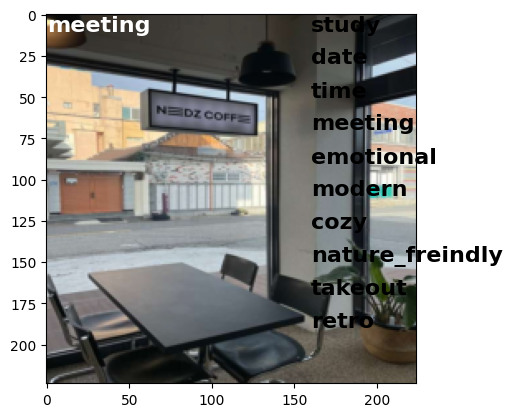

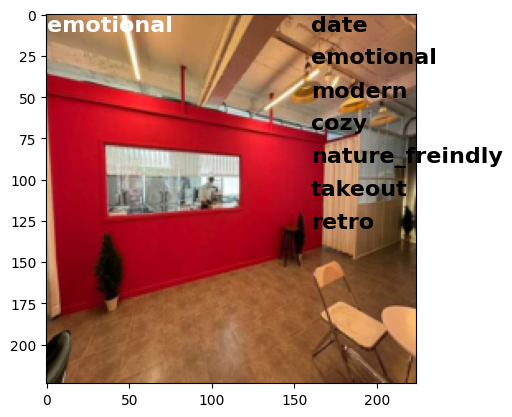

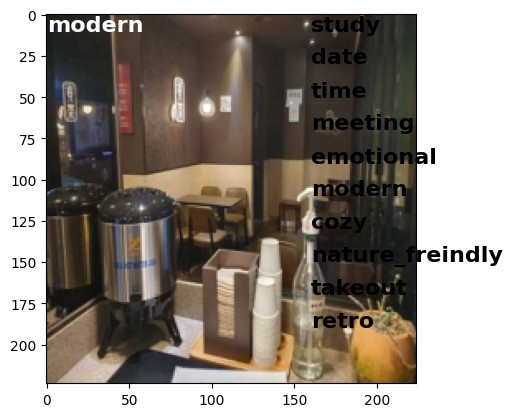

In [ ]:
visualize(image[0] , label[0].tolist() , output[0].tolist())
visualize(image[1] , label[1].tolist() , output[1].tolist())
visualize(image[2] , label[2].tolist() , output[2].tolist())